In [4]:
from platform import python_version
print(python_version())

3.8.8


In [1]:
!pip install -q imdb-sqlite #Pacote que contém um BD as informações do imdb

In [2]:
!pip install -q pycountry #pacote que contém os nomes dos países

In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [8]:
##Carregando dados

In [12]:
%%time
!imdb-sqlite

2022-01-05 18:30:49,731 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2022-01-05 18:31:07,372 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2022-01-05 18:31:15,238 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2022-01-05 18:31:23,767 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2022-01-05 18:31:46,010 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2022-01-05 18:31:47,297 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2022-01-05 18:31:47,584 Populating database: imdb.db
2022-01-05 18:31:47,585 Applying schema
2022-01-05 18:31:47,586 Importing file: downloads/name.basics.tsv.gz
2022-01-05 18:31:47,586 Reading number of rows ...
2022-01-05 18:31:52,861 Inserting rows into table: people
100%|█████████████████████████| 11310385/11310385 [04:15<00:00, 44222

In [2]:
conn = sqlite3.connect("imdb.db")

In [3]:
#FUNÇÃO DO PANDA(PD) PARA LER UMA QUERY. ARGUMENTOS SÃO: STRING, CONEXAO BD
tabelas = pd.read_sql_query("SELECT NAME AS 'table_name' FROM sqlite_master WHERE type = 'table'", conn)

In [4]:
type(tabelas)

pandas.core.frame.DataFrame

In [5]:
#HEAD É PARA LER EXIBIR A CONSULTA REALIZADA
tabelas.head()

,table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [6]:
tabelas = tabelas["table_name"].values.tolist()

In [7]:
#PRAGMA TABLE INFO({}) É PARA ENCONTRAR O SCHEMA DA TABELA, SQLITE
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




# Análise exploratória de dados

1 - Quais são as categorias de filmes mais comuns no IMDB?

In [8]:
#Para encontrar as respostas de forma menos dificil, tente entender o quadro geral, Big Picture. Compreender
# em linhas gerais o que deve ser feito e depois quebre em quadros menores

In [9]:
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type ORDER BY COUNT DESC'''

In [10]:
resultado1 = pd.read_sql_query(consulta1, conn)

In [11]:
display(resultado1)

,type,COUNT
0,tvEpisode,6404250
1,short,849453
2,movie,598170
3,video,256280
4,tvSeries,218814
5,tvMovie,134354
6,tvMiniSeries,41405
7,tvSpecial,35501
8,videoGame,30088
9,tvShort,10427


In [12]:
#entregando o resultado de forma percentual
resultado1['percentual1'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [13]:
display(resultado1)

,type,COUNT,percentual1
0,tvEpisode,6404250,74.652537
1,short,849453,9.901834
2,movie,598170,6.972699
3,video,256280,2.987384
4,tvSeries,218814,2.550653
5,tvMovie,134354,1.566127
6,tvMiniSeries,41405,0.482646
7,tvSpecial,35501,0.413825
8,videoGame,30088,0.350727
9,tvShort,10427,0.121545


In [14]:
#Criar com apenas 4 categorias
#3 categorias com mais titulos e 1 categoria com o restante

In [15]:
others = {}
others['COUNT'] = resultado1[resultado1['percentual1'] < 5.0]['COUNT'].sum()
others['percentual1'] = resultado1[resultado1['percentual1'] < 5.0]['percentual1'].sum()
others['type'] = 'others'

In [16]:
others

{'COUNT': 726871, 'percentual1': 8.472930303083995, 'type': 'others'}

In [17]:
resultado1 = resultado1[resultado1['percentual1'] > 5]

In [18]:
resultado1 = resultado1.append(others, ignore_index=True)

In [19]:
resultado1 = resultado1.sort_values(by = 'COUNT', ascending=False)

In [20]:
resultado1.head()

,type,COUNT,percentual1
0,tvEpisode,6404250,74.652537
1,short,849453,9.901834
3,others,726871,8.472930
2,movie,598170,6.972699


In [22]:
#listComprehension
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual1'][i], 2)) + '%'+']' for i in resultado1.index]

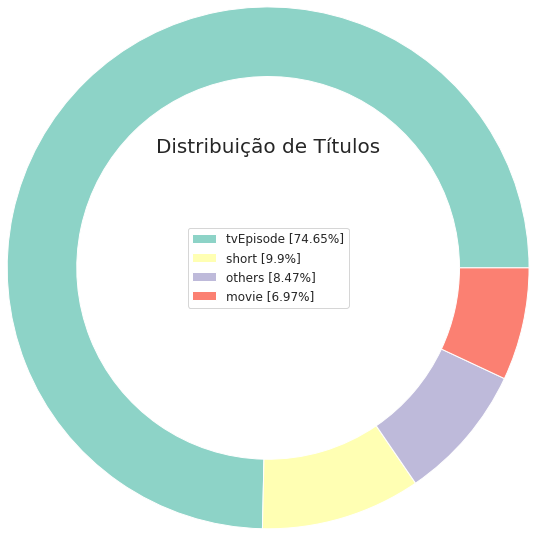

In [24]:
#plot
#mapa de cores matplotlip ColorMaps
cs = cm.Set3(np.arange(100))
f = plt.figure()

#Pie Plot
plt.pie(resultado1['COUNT'], labeldistance= 1, radius = 3, colors = cs, wedgeprops= dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title('Distribuição de Títulos', loc = 'Center', fontdict = {'fontsize':20, 'fontweight':20})
plt.show()